ROI (%): 4.89
Win Rate (%): 96.77
Max Drawdown: 1935.80 (0.19%)
Capital: 1048924.15
Total Trades: 248
Profitable Trades: 240
Losing Trades: 8
Hit Ratio: 0.97
Risk Reward: 0.30
Calmar Ratio: 25.27
Avg Return Per Trade: 197.27
Avg Profit Per Trade: 228.93
Avg Loss Per Trade: -752.44
Max Profit Per Trade: 525.35
Max Loss Per Trade: -905.00
Avg Return Per Month: 4125.01
Avg Return Per Year: 49500.13
Total Return: 48924.15
CAGR Return: 0.05


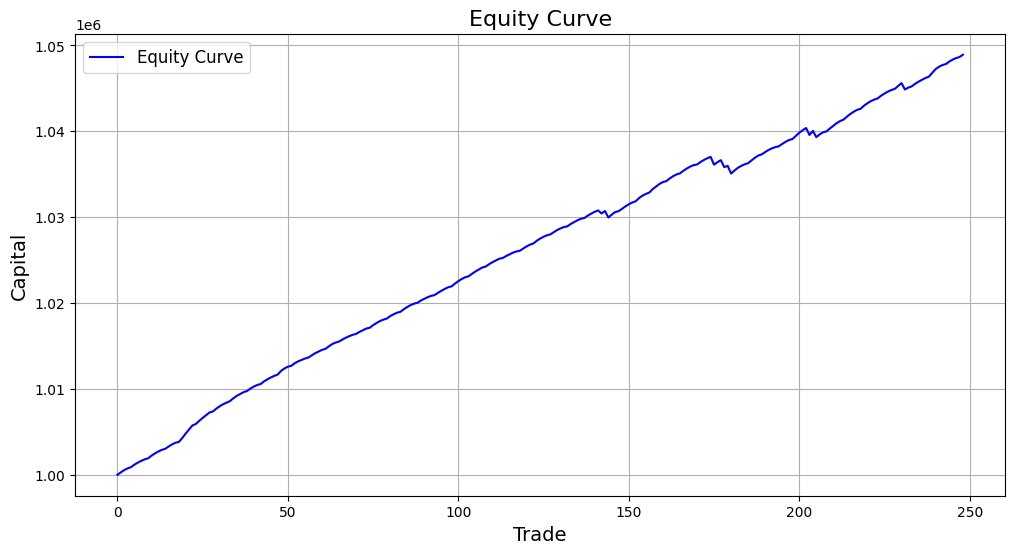

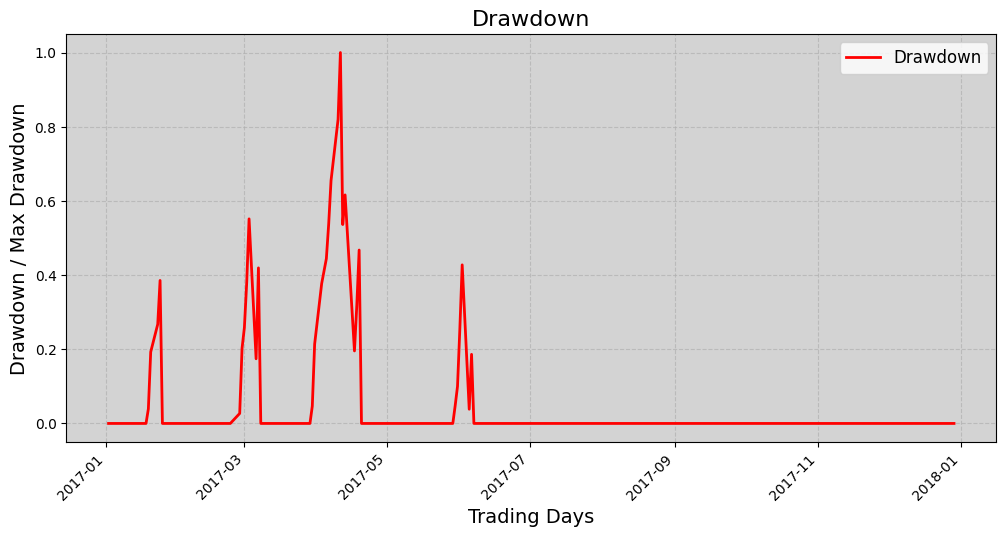

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Step 1: Data Preprocessing
options_data = pd.read_csv("C:\\Users\\Asus\\Desktop\\BANKNIFTY_FNO_Data_2017_New\\BANKNIFTY_FNO_Data_2017\\BANKNIFTY_2017_OPTIONS.csv")
futures_data = pd.read_csv("C:\\Users\\Asus\\Desktop\\BANKNIFTY_FNO_Data_2017_New\\BANKNIFTY_FNO_Data_2017\\BANKNIFTY_2017_FUTURES.csv")

options_data.dropna(inplace=True)
futures_data.dropna(inplace=True)

options_data['Date'] = pd.to_datetime(options_data['Date'])
futures_data['Date'] = pd.to_datetime(futures_data['Date'])

options_data['Contract_Weekly'] = pd.factorize(options_data['Contract_Weekly'])[0]
options_data['Contract_Monthly'] = pd.factorize(options_data['Contract_Monthly'])[0]

options_data.sort_values(['Date', 'Time'], inplace=True)
futures_data.sort_values(['Date', 'Time'], inplace=True)

# Step 2: Function Definitions
def find_atm_strike(date, futures_price):
    options_on_date = options_data[(options_data['Date'] == date) & (options_data['Contract_Weekly'] == 1)]
    if not options_on_date.empty:
        atm_strike_idx = options_on_date['Strike'].sub(futures_price).abs().idxmin()
        atm_strike = options_on_date.loc[atm_strike_idx, 'Strike']
        return atm_strike
    return None

def find_otm_strikes(atm_strike, percentage=0.02):
    call_strike = round(atm_strike * (1 + percentage), 3)
    put_strike = round(atm_strike * (1 - percentage), 3)
    return call_strike, put_strike

def calculate_premium(date, call_strike, put_strike):
    atm_call = options_data[(options_data['Date'] == date) & (options_data['Strike'] == call_strike) & (options_data['Type'] == 'CE') & (options_data['Contract_Weekly'] == 1)]
    atm_put = options_data[(options_data['Date'] == date) & (options_data['Strike'] == put_strike) & (options_data['Type'] == 'PE') & (options_data['Contract_Weekly'] == 1)]

    if not atm_call.empty and not atm_put.empty:
        premium_collected = atm_call['Close'].values[0] + atm_put['Close'].values[0]
    else:
        premium_collected = 0

    return premium_collected

def calculate_stop_loss(premium_collected):
    stop_loss = premium_collected * 1.3
    return stop_loss

def calculate_current_pnl(atm_call, atm_put, otm_call, otm_put, futures_price):
    atm_call_value = atm_put_value = otm_call_value = otm_put_value = 0

    if not atm_call.empty:
        atm_call_value = atm_call['Close'].values[0] - futures_price + atm_call['Strike'].values[0]

    if not atm_put.empty:
        atm_put_value = atm_put['Close'].values[0] + futures_price - atm_put['Strike'].values[0]

    if not otm_call.empty:
        otm_call_value = futures_price - otm_call['Strike'].values[0] - otm_call['Close'].values[0]

    if not otm_put.empty:
        otm_put_value = otm_put['Strike'].values[0] - futures_price - otm_put['Close'].values[0]

    pnl = atm_call_value + atm_put_value + otm_call_value + otm_put_value
    return pnl

def check_exit_conditions(premium_collected, current_pnl):
    stop_loss = premium_collected * 1.3
    target = premium_collected * 1.8
    if current_pnl <= -stop_loss:
        return True, "Stop Loss Hit"
    elif current_pnl >= target:
        return True, "Target Achieved"
    return False, None

def exit_trade_report(date, atm_call, atm_put, otm_call, otm_put, current_pnl, exit_reason):
    trade_report = {
        'Date': date,
        'ATM Call': {},
        'ATM Put': {},
        'OTM Call': {},
        'OTM Put': {},
        'P&L': current_pnl,
        'Exit Reason': exit_reason
    }

    if not atm_call.empty:
        trade_report['ATM Call'] = {'Strike': atm_call['Strike'].values[0], 'Premium': atm_call['Close'].values[0]}

    if not atm_put.empty:
        trade_report['ATM Put'] = {'Strike': atm_put['Strike'].values[0], 'Premium': atm_put['Close'].values[0]}

    if not otm_call.empty:
        trade_report['OTM Call'] = {'Strike': otm_call['Strike'].values[0], 'Premium': otm_call['Close'].values[0]}

    if not otm_put.empty:
        trade_report['OTM Put'] = {'Strike': otm_put['Strike'].values[0], 'Premium': otm_put['Close'].values[0]}

    return trade_report

# Step 3: Backtesting
def execute_trade(date, futures_price):
    atm_strike = find_atm_strike(date, futures_price)
    if atm_strike is None:
        return None

    call_strike, put_strike = find_otm_strikes(atm_strike)

    atm_call = options_data[(options_data['Date'] == date) & (options_data['Strike'] == atm_strike) & (options_data['Type'] == 'CE') & (options_data['Contract_Weekly'] == 1)]
    atm_put = options_data[(options_data['Date'] == date) & (options_data['Strike'] == atm_strike) & (options_data['Type'] == 'PE') & (options_data['Contract_Weekly'] == 1)]
    otm_call = options_data[(options_data['Date'] == date) & (options_data['Strike'] == call_strike) & (options_data['Type'] == 'CE') & (options_data['Contract_Weekly'] == 1)]
    otm_put = options_data[(options_data['Date'] == date) & (options_data['Strike'] == put_strike) & (options_data['Type'] == 'PE') & (options_data['Contract_Weekly'] == 1)]

    premium_collected = calculate_premium(date, call_strike, put_strike)
    stop_loss = calculate_stop_loss(premium_collected)

    current_pnl = 0
    exit_trade = False
    exit_reason = None

    while not exit_trade:
        current_pnl = calculate_current_pnl(atm_call, atm_put, otm_call, otm_put, futures_price)
        exit_trade, exit_reason = check_exit_conditions(premium_collected, current_pnl)

        if exit_trade or (date.time() >= pd.Timestamp(date.date(), tz='UTC').time().replace(hour=15, minute=20)):
            break

        date += pd.Timedelta(days=1)
        if date in futures_data['Date'].values:
            futures_price = futures_data.loc[futures_data['Date'] == date, 'Close'].values[0]
        else:
            break

    trade_report = exit_trade_report(date, atm_call, atm_put, otm_call, otm_put, current_pnl, exit_reason)
    return trade_report

def calculate_returns(trades, starting_capital=1000000, transaction_costs=0):
    capital = starting_capital
    returns = [capital]
    for trade in trades:
        if trade is not None:
            capital += trade['P&L'] - transaction_costs
        returns.append(capital)
    return returns

def calculate_performance_stats(returns, trades, starting_capital):
    roi = (returns[-1] - returns[0]) / returns[0] * 100
    win_rate = len([trade for trade in trades if trade is not None and trade['P&L'] > 0]) / len([trade for trade in trades if trade is not None]) * 100
    max_drawdown = np.maximum.accumulate(returns) - returns
    max_drawdown = max(max_drawdown)
    max_drawdown_pct = max_drawdown / returns[0] * 100
    total_trades = len([trade for trade in trades if trade is not None])
    profitable_trades = len([trade for trade in trades if trade is not None and trade['P&L'] > 0])
    losing_trades = len([trade for trade in trades if trade is not None and trade['P&L'] < 0])
    hit_ratio = profitable_trades / total_trades
    risk_reward = np.mean([trade['P&L'] for trade in trades if trade is not None and trade['P&L'] > 0]) / np.abs(np.mean([trade['P&L'] for trade in trades if trade is not None and trade['P&L'] < 0]))
    calmar_ratio = (returns[-1] - returns[0]) / max_drawdown
    avg_return_per_trade = np.mean([trade['P&L'] for trade in trades if trade is not None])
    avg_profit_per_trade = np.mean([trade['P&L'] for trade in trades if trade is not None and trade['P&L'] > 0])
    avg_loss_per_trade = np.mean([trade['P&L'] for trade in trades if trade is not None and trade['P&L'] < 0])
    max_profit_per_trade = max([trade['P&L'] for trade in trades if trade is not None and trade['P&L'] > 0])
    max_loss_per_trade = min([trade['P&L'] for trade in trades if trade is not None and trade['P&L'] < 0])
    avg_return_per_month = (returns[-1] - returns[0]) / (max(futures_data['Date']) - min(futures_data['Date'])).days * 30.4375
    avg_return_per_year = (returns[-1] - returns[0]) / (max(futures_data['Date']) - min(futures_data['Date'])).days * 365.25
    total_return = returns[-1] - returns[0]
    cagr_return = (returns[-1] / returns[0]) ** (1 / ((max(futures_data['Date']) - min(futures_data['Date'])).days / 365.25)) - 1

    performance_stats = {
        'ROI (%)': roi,
        'Win Rate (%)': win_rate,
        'Max Drawdown': max_drawdown,
        'Max Drawdown (%)': max_drawdown_pct,
        'Capital': returns[-1],
        'Total Trades': total_trades,
        'Profitable Trades': profitable_trades,
        'Losing Trades': losing_trades,
        'Hit Ratio': hit_ratio,
        'Risk Reward': risk_reward,
        'Calmar Ratio': calmar_ratio,
        'Avg Return Per Trade': avg_return_per_trade,
        'Avg Profit Per Trade': avg_profit_per_trade,
        'Avg Loss Per Trade': avg_loss_per_trade,
        'Max Profit Per Trade': max_profit_per_trade,
        'Max Loss Per Trade': max_loss_per_trade,
        'Avg Return Per Month': avg_return_per_month,
        'Avg Return Per Year': avg_return_per_year,
        'Total Return': total_return,
        'CAGR Return': cagr_return
    }
    return performance_stats

# Step 4: Results Visualization
def plot_equity_curve(returns):
    plt.figure(figsize=(12, 6))
    plt.plot(returns, color='blue', label='Equity Curve')
    plt.title('Equity Curve', fontsize=16)
    plt.xlabel('Trade', fontsize=14)
    plt.ylabel('Capital', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()

def plot_drawdown(drawdown, trading_days):
    # Trim drawdown to match the length of trading_days and reverse the order
    drawdown = drawdown[:len(trading_days)][::-1]

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(trading_days, drawdown / max(drawdown), color='r', lw=2, label='Drawdown')
    ax.set_title('Drawdown', fontsize=16)
    ax.set_xlabel('Trading Days', fontsize=14)
    ax.set_ylabel('Drawdown / Max Drawdown', fontsize=14)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.legend(fontsize=12)

    # Colorful background
    ax.set_facecolor('lightgray')

    # Rotate and align x-axis labels
    fig.autofmt_xdate()
    plt.xticks(rotation=45, ha='right')

    plt.show()


# Run backtesting and obtain returns
trades = []
starting_capital = 1000000

trading_days = []
for date in futures_data['Date'].unique():
    futures_price = futures_data.loc[futures_data['Date'] == date, 'Close'].values[0]
    trade_report = execute_trade(date, futures_price)
    trades.append(trade_report)
    trading_days.append(date)

returns = calculate_returns(trades, starting_capital, transaction_costs=0)
performance_stats = calculate_performance_stats(returns, trades, starting_capital)
print(f"ROI (%): {performance_stats['ROI (%)']:.2f}")
print(f"Win Rate (%): {performance_stats['Win Rate (%)']:.2f}")
print(f"Max Drawdown: {performance_stats['Max Drawdown']:.2f} ({performance_stats['Max Drawdown (%)']:.2f}%)")
print(f"Capital: {performance_stats['Capital']:.2f}")
print(f"Total Trades: {performance_stats['Total Trades']}")
print(f"Profitable Trades: {performance_stats['Profitable Trades']}")
print(f"Losing Trades: {performance_stats['Losing Trades']}")
print(f"Hit Ratio: {performance_stats['Hit Ratio']:.2f}")
print(f"Risk Reward: {performance_stats['Risk Reward']:.2f}")
print(f"Calmar Ratio: {performance_stats['Calmar Ratio']:.2f}")
print(f"Avg Return Per Trade: {performance_stats['Avg Return Per Trade']:.2f}")
print(f"Avg Profit Per Trade: {performance_stats['Avg Profit Per Trade']:.2f}")
print(f"Avg Loss Per Trade: {performance_stats['Avg Loss Per Trade']:.2f}")
print(f"Max Profit Per Trade: {performance_stats['Max Profit Per Trade']:.2f}")
print(f"Max Loss Per Trade: {performance_stats['Max Loss Per Trade']:.2f}")
print(f"Avg Return Per Month: {performance_stats['Avg Return Per Month']:.2f}")
print(f"Avg Return Per Year: {performance_stats['Avg Return Per Year']:.2f}")
print(f"Total Return: {performance_stats['Total Return']:.2f}")
print(f"CAGR Return: {performance_stats['CAGR Return']:.2f}")

plot_equity_curve(returns)

# Calculate drawdown and plot it
drawdown = np.maximum.accumulate(returns) - returns
plot_drawdown(drawdown, trading_days)